In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pathlib

print(f'tensorflow version: {tf.__version__}')
print(f'pandas version: {pd.__version__}')
print(f'numpy version: {np.__version__}')
print(f'seaborn version: {sns.__version__}')

# check tensorflow GPU device support
if len(tf.config.list_physical_devices('GPU')) > 0:
    print('GPU present')
else:
    print('GPU absent')

tensorflow version: 2.6.0
pandas version: 1.3.2
numpy version: 1.20.3
seaborn version: 0.11.2
GPU present


2021-11-11 17:15:00.112527: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-11 17:15:00.118725: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-11 17:15:00.119191: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Data Importing and Wrangling

In [2]:
# paths to load datasets from
train_store_path = './datasets/sa/training'
val_store_path = './datasets/sa/validation'

# convert to pathlib Path objects
train_dir = pathlib.Path(train_store_path)
val_dir = pathlib.Path(val_store_path)

# get list of datasets in dir
train_ds_paths = sorted(list(train_dir.glob('*.csv')))
val_ds_paths = sorted(list(val_dir.glob('*.csv')))

# extract classification target from file names
train_ds_type = np.array([x.parts[-1].split('_')[:2] for x in train_ds_paths])
val_ds_type = np.array([x.parts[-1].split('_')[:2] for x in val_ds_paths])

train_ds_order = [s.upper() for s in train_ds_type[:,0]]
val_ds_order = [s.upper() for s in val_ds_type[:,0]]

train_ds_loc = [s.upper() for s in train_ds_type[:, 1]]
val_ds_loc = [s.upper() for s in val_ds_type[:, 1]]

# generate signal type tags
signal_tags = {k : i for i, k in enumerate(np.unique(sorted([s.upper() for s in train_ds_order])))}

In [3]:
# load the dataset(s)

# load dataset information
specs = []
datasets = []

for dataset_paths in [train_ds_paths, val_ds_paths]:
    temp_ds = []
    temp_specs = []
    
    for path in dataset_paths:
        print(f'loading {path}...', end=' ')

        # load dataset details
        df_spec = pd.read_csv(path, nrows=10, header=None, index_col=0, names=['info'])
        df_spec = df_spec.drop(['Version', 'DateTime', 'TimestampOffset', 'TriggerPosition', 'FastFrameID', 'IDInFastFrame', 'TotalInFastFrame'], axis=0).astype('int')

        temp_specs.append(df_spec)

        # load data, strip unnecessary bits out
        df = pd.read_csv(path, skiprows=10, names=['I', 'Q'])
        df = df.loc[~df['I'].isin(['TimestampOffset', 'TriggerPosition', 'FastFrameID', 'IDInFastFrame', 'TotalInFastFrame'])]
        df['I'] = df['I'].astype('float')

        print(f'loaded')

        temp_ds.append(df)
        
    datasets.append(temp_ds)
    specs.append(temp_specs)
    
print('done.')

loading datasets/sa/training/bt_library_1.csv... loaded
loading datasets/sa/training/bt_office_1.csv... loaded
loading datasets/sa/training/bt_room_1.csv... loaded
loading datasets/sa/training/fm_roof_1.csv... loaded
loading datasets/sa/training/fnet_library_1.csv... loaded
loading datasets/sa/training/fnet_roof_1.csv... loaded
loading datasets/sa/training/fnet_room_1.csv... loaded
loading datasets/sa/training/lte_library_1.csv... loaded
loading datasets/sa/training/lte_library_2.csv... loaded
loading datasets/sa/training/lte_library_3.csv... loaded
loading datasets/sa/training/lte_office_1.csv... loaded
loading datasets/sa/training/lte_office_2.csv... loaded
loading datasets/sa/training/lte_room_1.csv... loaded
loading datasets/sa/training/lte_room_2.csv... loaded
loading datasets/sa/training/lte_room_3.csv... loaded
loading datasets/sa/training/wifi_library_1.csv... loaded
loading datasets/sa/training/wifi_library_2.csv... loaded
loading datasets/sa/training/wifi_library_3.csv... loa

In [4]:
# split dataset(s) into records, extract test dataset
processed = []

# number of test records to extract
ntest = 100
rlength = 1024

for h in range(len(datasets)):
    temp_processed = []
    
    print(f'\nType\t\tLocation\tTotal Records\tSamples/Record')
    for i in range(len(datasets[h])):
        nrecords = specs[h][i].loc['NumberRecords']['info'] if not h else 400
        nsamples = specs[h][i].loc['NumberSamples']['info']
        ds_length = datasets[h][i].shape[0]
        
        # make life easier
        ds_order = train_ds_order if not h else val_ds_order
        ds_loc = train_ds_loc if not h else val_ds_loc

        # sanity check
        print(f'{ds_order[i]:<13}\t{ds_loc[i]:<15}\t{nrecords:<7}\t\t{nsamples:<7}')

        # loop through dataset to split 
        for j in range(nrecords):
            # extract sample length worth of samples for each record, then transpose for easier access later
            record = datasets[h][i].iloc[(nsamples * j):(nsamples * (j+1))].values.T

            # pad shorter records with random padding to rlength
            if nsamples < rlength:
                # deterine pad amount
                pad_length = rlength - nsamples
                lpad_length = np.random.randint(0, pad_length+1)
                rpad_length = pad_length - lpad_length

                # generate pad
                lpad = np.zeros((2, lpad_length))
                rpad = np.zeros((2, rpad_length))

                # concatenate pad
                record = np.concatenate([lpad, record, rpad], axis=1)

            # truncate longer records to rlength
            elif nsamples > rlength:
                record = record[:,:rlength]

            # add processed record to list
            temp_processed.append([ds_order[i], signal_tags[ds_order[i]], ds_loc[i], record])
            
    processed.append(temp_processed)

# convert list into dataframes for later use, randomise, extract test records
df_train = pd.DataFrame(processed[0], columns=['signal_type', 'tag', 'location', 'record']).sample(frac=1, random_state=42)
df_test = pd.DataFrame(processed[1], columns=['signal_type', 'tag', 'location', 'record']).sample(frac=1, random_state=42)

# print dataset statistics
print(f'\n{"Stats":^30}')
print(f'Dataset\tLength\tRecords/Sample')
print(f'Train\t{df_train.shape[0]:<5}\t{df_train["record"].iloc[0].shape[1]}')
print(f'Test\t{df_test.shape[0]:<5}\t{df_train["record"].iloc[0].shape[1]}')


Type		Location	Total Records	Samples/Record
BT           	LIBRARY        	5869   		1024   
BT           	OFFICE         	23885  		1014   
BT           	ROOM           	9000   		1024   
FM           	ROOF           	5300   		1280   
FNET         	LIBRARY        	6343   		1024   
FNET         	ROOF           	3151   		1024   
FNET         	ROOM           	2450   		1024   
LTE          	LIBRARY        	1200   		1024   
LTE          	LIBRARY        	1450   		1024   
LTE          	LIBRARY        	1500   		1024   
LTE          	OFFICE         	3202   		1014   
LTE          	OFFICE         	3550   		1014   
LTE          	ROOM           	1850   		1024   
LTE          	ROOM           	1650   		1024   
LTE          	ROOM           	1300   		1024   
WIFI         	LIBRARY        	1250   		1024   
WIFI         	LIBRARY        	1200   		1024   
WIFI         	LIBRARY        	1350   		1024   
WIFI         	OFFICE         	1200   		1014   
WIFI         	OFFICE         	2699   		1014   
WIFI         	R

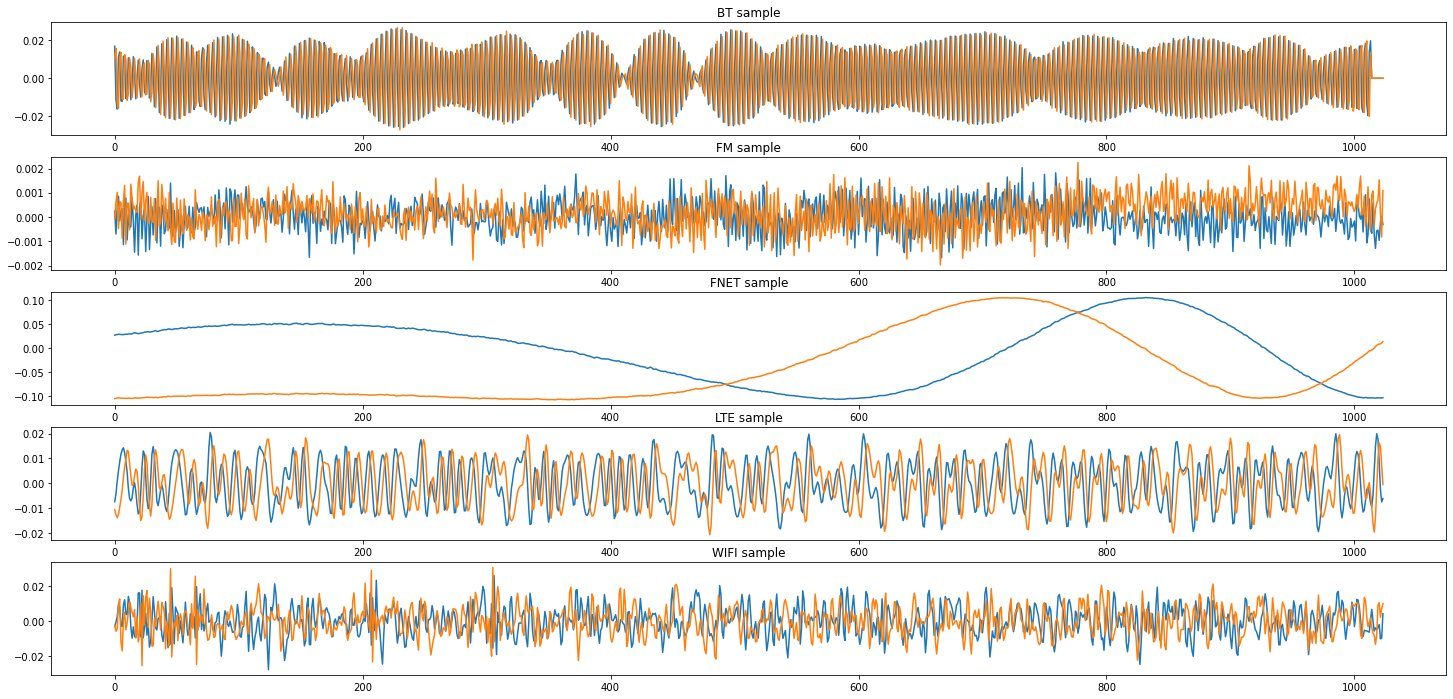

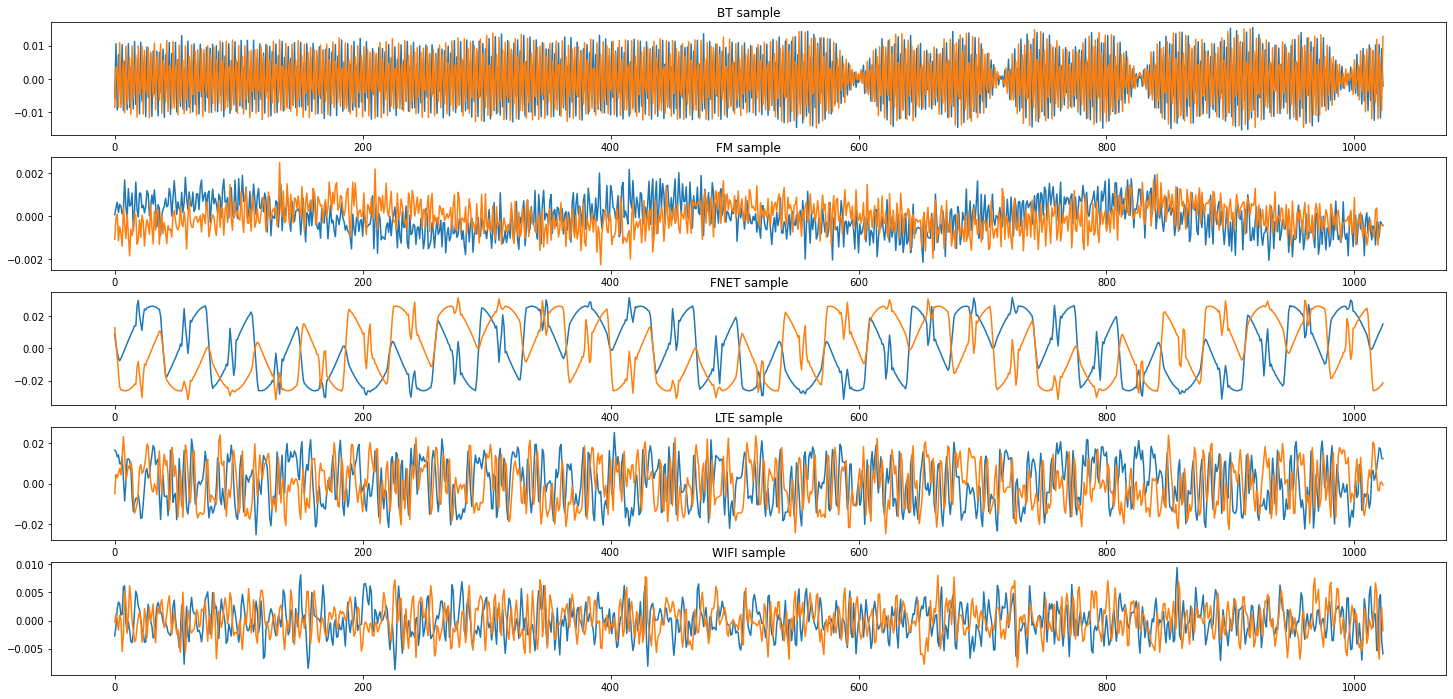

In [5]:
# plot some sample signals
fig1 = plt.figure(1, figsize=(25, 12))
fig2 = plt.figure(2, figsize=(25, 12))

for i, key in enumerate(list(signal_tags.keys())):
    # training data
    ip, qd = df_train[df_train['signal_type'] == key]['record'].sample().iloc[0]
    
    ax = fig1.add_subplot(5, 1, i+1)

    ax.plot(ip)
    ax.plot(qd)
    
    ax.set_title(f'{key} sample')
    
    # validation data
    ip, qd = df_test[df_test['signal_type'] == key]['record'].sample().iloc[0]
    
    ax = fig2.add_subplot(5, 1, i+1)

    ax.plot(ip)
    ax.plot(qd)
    
    ax.set_title(f'{key} sample')
    
plt.show()

## Data Preparation for Training

In [6]:
# define one hot encode function
def one_hot(arr, n_cat):
    output = []
    for n in arr:
        result = np.zeros(n_cat)
        result[n] = 1

        output.append(result)

    return np.array(output, dtype=int)

In [7]:
# extract train and test data
X_train = np.concatenate(df_train['record'].values).reshape((df_train.shape[0], 2, rlength, 1))
y_train = one_hot(df_train['tag'].values, len(signal_tags))

X_test = np.concatenate(df_test['record'].values).reshape((df_test.shape[0], 2, rlength, 1))
y_test = one_hot(df_test['tag'].values, len(signal_tags))

## Model Training and Testing

In [8]:
# import model stuff
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling2D, Dropout, AveragePooling2D, concatenate, ReLU, Dense, Input, Flatten

In [9]:
# functions to create Inception-ResNet sections
def stem(x):
    x = Conv2D(32, (1, 3), strides=2, padding='same', activation='relu')(x)
    x = Conv2D(32, (1, 3), activation='relu')(x)
    x = Conv2D(64, (1, 3), activation='relu')(x)
    x = MaxPooling2D((1, 3), strides=2)(x)
    x = Conv2D(80, 1, padding='same', activation='relu')(x)
    x = Conv2D(192, (1, 3), activation='relu')(x)
    x = Conv2D(192, (1, 3), strides=2, activation='relu')(x)

    return x

def res_incep_A(x, n_modules):
    for _ in range(n_modules):
        x = ReLU()(x)
        
        # parallel paths
        a = Conv2D(32, 1, padding='same', activation='relu')(x)

        b = Conv2D(32, 1, padding='same', activation='relu')(x)
        b = Conv2D(32, (1, 3), padding='same', activation='relu')(b)

        c = Conv2D(32, 1, padding='same', activation='relu')(x)
        c = Conv2D(48, 3, padding='same', activation='relu')(c)
        c = Conv2D(64, 3, padding='same', activation='relu')(c)

        # converge parallel paths
        converge = concatenate([a, b, c])
        converge = Conv2D(320, 1, activation='relu')(converge)

        # skip-con
        x = concatenate([x, converge])
        x = ReLU()(x)
    
    return x

def res_incep_B(x, n_modules):
    for _ in range(n_modules):
        x = ReLU()(x)
        
        # parallel paths
        a = Conv2D(192, 1, padding='same', activation='relu')(x)

        b = Conv2D(128, 1, padding='same', activation='relu')(x)
        b = Conv2D(160, (1, 7), padding='same', activation='relu')(b)
        b = Conv2D(192, (7, 1), padding='same', activation='relu')(b)

        # converge parallel paths
        converge = concatenate([a, b])
        converge = Conv2D(1088, 1, activation='relu')(converge)

        # skip-con
        x = concatenate([x, converge])
        x = ReLU()(x)
    
    return x

def res_incep_C(x, n_modules):
    for _ in range(n_modules):
        x = ReLU()(x)
        
        # parallel paths
        a = Conv2D(192, 1, padding='same', activation='relu')(x)

        b = Conv2D(192, 1, padding='same', activation='relu')(x)
        b = Conv2D(224, (1, 7), padding='same', activation='relu')(b)
        b = Conv2D(256, (7, 1), padding='same', activation='relu')(b)

        # converge parallel paths
        converge = concatenate([a, b])
        converge = Conv2D(1536, 1)(converge)

        # skip-con
        x = concatenate([x, converge])
        x = ReLU()(x)
    
    return x

In [10]:
# create main model
def create_model(in_dim, out_dim):
    '''
    function used to create Inception-ResNet RF model.

    INPUT PARAMETERS
    in_dim: dimensions of input layer
    
    out_dim: dimensions of output layer
    '''
    input_layer = Input(in_dim)

    print(input_layer.shape.dims)
    
    stem_block = stem(input_layer)

    print(stem_block.shape.dims)

    # block A
    a = res_incep_A(stem_block, 5)
    a = Conv1D(1088, 1, activation='relu')(a)

    # block B
    b = res_incep_B(a, 10)
    b = Conv1D(2080, 1, activation='relu')(b)

    # block C
    c = res_incep_C(b, 5)

    # rest of model
    x = AveragePooling2D(pool_size=(1, 2))(c)
    x = Flatten()(x)
    x = Dropout(0.2)(x)

    # output
    x = Dense(out_dim, activation='softmax')(x)

    # put model together
    model = Model(inputs=input_layer, outputs=x, name='rf_classification_model')
    
    return model

In [11]:
# create model
model = create_model((2, rlength, 1), len(signal_tags))

# tf.keras.utils.plot_model(model, show_shapes=True)
model.summary()

[Dimension(None), Dimension(2), Dimension(1024), Dimension(1)]


2021-11-11 17:15:50.004921: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-11 17:15:50.005421: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-11 17:15:50.005883: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-11 17:15:50.006261: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

[Dimension(None), Dimension(1), Dimension(125), Dimension(192)]
Model: "rf_classification_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2, 1024, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 1, 512, 32)   128         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1, 510, 32)   3104        conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 1, 508, 64)   6208        conv2d_1[0][0]                   
____________

In [12]:
# train model
# import metrics
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

#early stopping
callback = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')

model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=16, callbacks=[callback], validation_split=0.2)

2021-11-11 17:15:51.433279: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2021-11-11 17:15:55.124771: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2021-11-11 17:15:55.720759: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-11-11 17:15:55.721182: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-11-11 17:15:55.721198: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2021-11-11 17:15:55.721611: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-11-11 17:15:55.721679: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2021-11-11 17:15:56.853504: W tensorflow/core/common_runtime/bf

4242/4243 [============================>.] - ETA: 0s - loss: 1.4179 - accuracy: 0.4550

2021-11-11 17:27:57.311677: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.96GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-11-11 17:27:57.311715: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.96GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-11-11 17:27:58.066169: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.19GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-11-11 17:27:58.066210: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Alloc

4243/4243 [==============================] - 789s 184ms/step - loss: 1.4178 - accuracy: 0.4551 - val_loss: 1.4047 - val_accuracy: 0.4633
Epoch 2/10
4243/4243 [==============================] - 780s 184ms/step - loss: 1.4129 - accuracy: 0.4551 - val_loss: 1.3994 - val_accuracy: 0.4633
Epoch 3/10
1131/4243 [======>.......................] - ETA: 8:48 - loss: 1.4073 - accuracy: 0.4565

KeyboardInterrupt: 